<a href="https://colab.research.google.com/github/seyonechithrananda/deep-bind-tensorflow/blob/master/kipoi_interpret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install concise
!pip install kipoi
!pip install kipoi_interpret
!pip install kipoi_veff
import kipoi
import kipoi_interpret
from kipoi_veff.utils.plot import seqlogo_heatmap
from concise.preprocessing.sequence import encodeDNA


     |████████████████████████████████| 9.7MB 2.8MB/s 
     |████████████████████████████████| 317kB 41.9MB/s 
  Created wheel for concise: filename=concise-0.6.8-py2.py3-none-any.whl size=122598 sha256=509334b47271c319b56983af3bffd5cef857244308bdcc1fc48f738210a06988
  Stored in directory: /root/.cache/pip/wheels/83/6c/9e/b3625da47c5baedbce45cd48cacd16fb624fa3117136418f54
  Created wheel for gtfparse: filename=gtfparse-1.2.0-cp36-none-any.whl size=11883 sha256=de289e0b06eb736dab0e9144f1baa616940a836eb2c0d7a09ed3347822d81fc4
  Stored in directory: /root/.cache/pip/wheels/c4/27/96/6ba6fe28cbb162c326823553e3e45ac502160d1340566360f8
Successfully built concise gtfparse
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for kipoi-utils: filename=kipoi_

/usr/local/lib/python3.6/dist-packages/kipoi_veff/external/concise/seqplotting_deps.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/usr/local/lib/python3.6/dist-packages/kipoi_veff/external/concise/seqplotting_deps.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)
Using TensorFlow backend.


In [20]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import numpy as np
import csv
import math 
import random
import gzip
from scipy.stats import bernoulli


In [22]:
# list all available methods
kipoi_interpret.importance_scores.available_methods()


{'deeplift': kipoi_interpret.importance_scores.referencebased.DeepLift,
 'grad': kipoi_interpret.importance_scores.gradient.Gradient,
 'grad*input': kipoi_interpret.importance_scores.gradient.GradientXInput,
 'intgrad': kipoi_interpret.importance_scores.referencebased.IntegratedGradients,
 'mutation': kipoi_interpret.importance_scores.ism.Mutation,
 'saliency': kipoi_interpret.importance_scores.gradient.Saliency}

In [0]:
# Gradient-based methods
from kipoi_interpret.importance_scores.gradient import Gradient, GradientXInput
# In-silico mutagenesis-based methods
from kipoi_interpret.importance_scores.ism import Mutation
# DeepLift
from kipoi_interpret.importance_scores.referencebased import DeepLift


In [0]:
nummotif=16 #number of motifs to discover
bases='ACGT' #DNA bases
basesRNA='ACGU'#RNA bases
batch_size=64 #fixed batch size -> see notes to problem about it
dictReverse={'A':'T','C':'G','G':'C','T':'A','N':'N'} #dictionary to implement reverse-complement mode


In [0]:
class Experiment:
    def __init__(self,filename,motiflen):
        self.file=filename
        self.motiflen=motiflen
    
    def getMotifLen(self):
        return self.motiflen

# pads sequence 
def seqtopad(sequence,motlen,kind='DNA'):
    rows=len(sequence)+2*motlen-2
    S=np.empty([rows,4])
    base= bases if kind=='DNA' else basesRNA
    for i in range(rows):
        for j in range(4):
            if i-motlen+1<len(sequence) and sequence[i-motlen+1]=='N' or i<motlen-1 or i>len(sequence)+motlen-2:
                S[i,j]=np.float32(0.25)
            elif sequence[i-motlen+1]==base[j]:
                S[i,j]=np.float32(1)
            else:
                S[i,j]=np.float32(0)
    return S

# shuffles sequence
def dinucshuffle(sequence):
    b=[sequence[i:i+2] for i in range(0, len(sequence), 2)]
    random.shuffle(b)
    d=''.join([str(x) for x in b])
    return d
# generates real number in some interval, (a, b)
def logsampler(a,b):
    x=tf.Variable(tf.random_uniform([],minval=0,maxval=1), trainable=False)
    y=10**((math.log10(b)-math.log10(a))*x + math.log10(a))
    
#     x=np.random.uniform(low=0,high=1)
#     y=10**((math.log10(b)-math.log10(a))*x + math.log10(a))
    return y

# generates real number in some interval, less aggressively skewed towards b
def sqrtsampler(a,b):
    x=tf.Variable(tf.random_uniform([],minval=0,maxval=1), trainable=False)
#     x=np.random.uniform(low=0,high=1)
    y=(b-a)*(x**0.5)+a
    return y


# processes ChIP-seq data
class Chip(Experiment):
    def __init__(self,filename,motiflen=24):
        self.file = filename
        self.motiflen = motiflen
            
    def openFile(self):
        train_dataset=[]
     
        with gzip.open(self.file, 'rt') as data:
            next(data)
            reader = csv.reader(data,delimiter='\t')
            
            for row in reader:
                    train_dataset.append([seqtopad(row[2],self.motiflen),[1]])
                    
                    train_dataset.append([seqtopad(dinucshuffle(row[2]),self.motiflen),[0]])
                   
        
        
        random.shuffle(train_dataset)
        frac1=int(len(train_dataset)*1/3)
        frac2=int(len(train_dataset)*2/3)
        return train_dataset[:frac1],train_dataset[frac1:frac2],train_dataset[frac2:],train_dataset


In [0]:
filename='/content/drive/My Drive/replicate 2 /ELK1_GM12878_ELK1_(1277-1)_Stanford_AC.seq.gz'


In [0]:

test= Chip(filename)
d1,d2,d3,dataAll =test.openFile()

data1=np.asarray([el[0] for el in d1],dtype=np.float32)
label1=np.asarray([el[1] for el in d1],dtype=np.float32).reshape(len(data1),1)

data2=np.asarray([el[0] for el in d2],dtype=np.float32)
label2=np.asarray([el[1] for el in d2],dtype=np.float32).reshape(len(data2),1)

data3=np.asarray([el[0] for el in d3],dtype=np.float32)
label3=np.asarray([el[1] for el in d3],dtype=np.float32).reshape(len(data3),1)

data=[data1,data2,data3]
label=[label1,label2,label3]

data_all=np.asarray([el[0] for el in dataAll],dtype=np.float32)
label_all=np.asarray([el[1] for el in dataAll],dtype=np.float32).reshape(len(data_all),1)


In [30]:
!pip install kipoiseq
import kipoiseq
model = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF")

     |████████████████████████████████| 1.5MB 7.6MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 266kB 50.8MB/s 
  Created wheel for gffutils: filename=gffutils-0.9-cp36-none-any.whl size=1601964 sha256=c398676e2aa06db51c6a57508e324cc330fb0934de51ee5ef1fab0e890f14a79
  Stored in directory: /root/.cache/pip/wheels/21/f2/ae/f1add52abe461ab73068c96953c2aa703f5fc23b81879bef94
  Created wheel for pyfaidx: filename=pyfaidx-0.5.6-cp36-none-any.whl size=24992 sha256=897a4b16ad348de780a0e8f7268eac679f71396aadd8e3cca9e295c3df3a6b2f
  Stored in directory: /root/.cache/pip/wheels/f2/54/96/c52b85c5d8968e75db8aa429de2f2e7d12e6c4b4c112c93555
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114211 sha256=9bba8cd562aadd438446a5a08f4af16aee8412c5f81a928e2c3150cb07fc015a
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
  Created wheel for PyYAML: filena

0.00B [00:00, ?B/s]

8.19kB [00:02, 4.03kB/s]
0.00B [00:00, ?B/s]

32.8kB [00:01, 20.8kB/s]                            


In [0]:
# compute gradient over masked input
grxinp = GradientXInput(model)
# score gradient for input data
val = grxinp.score(data1)[0]

In [0]:
import matplotlib.pyplot as plt

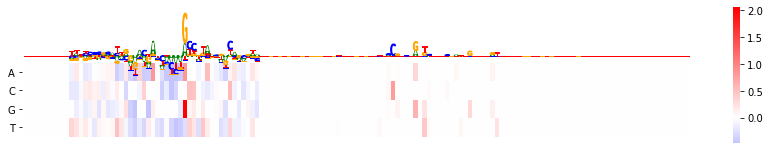

In [45]:
# visualize importance scores (height = importance towards transcription-factor DNA binding)
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())


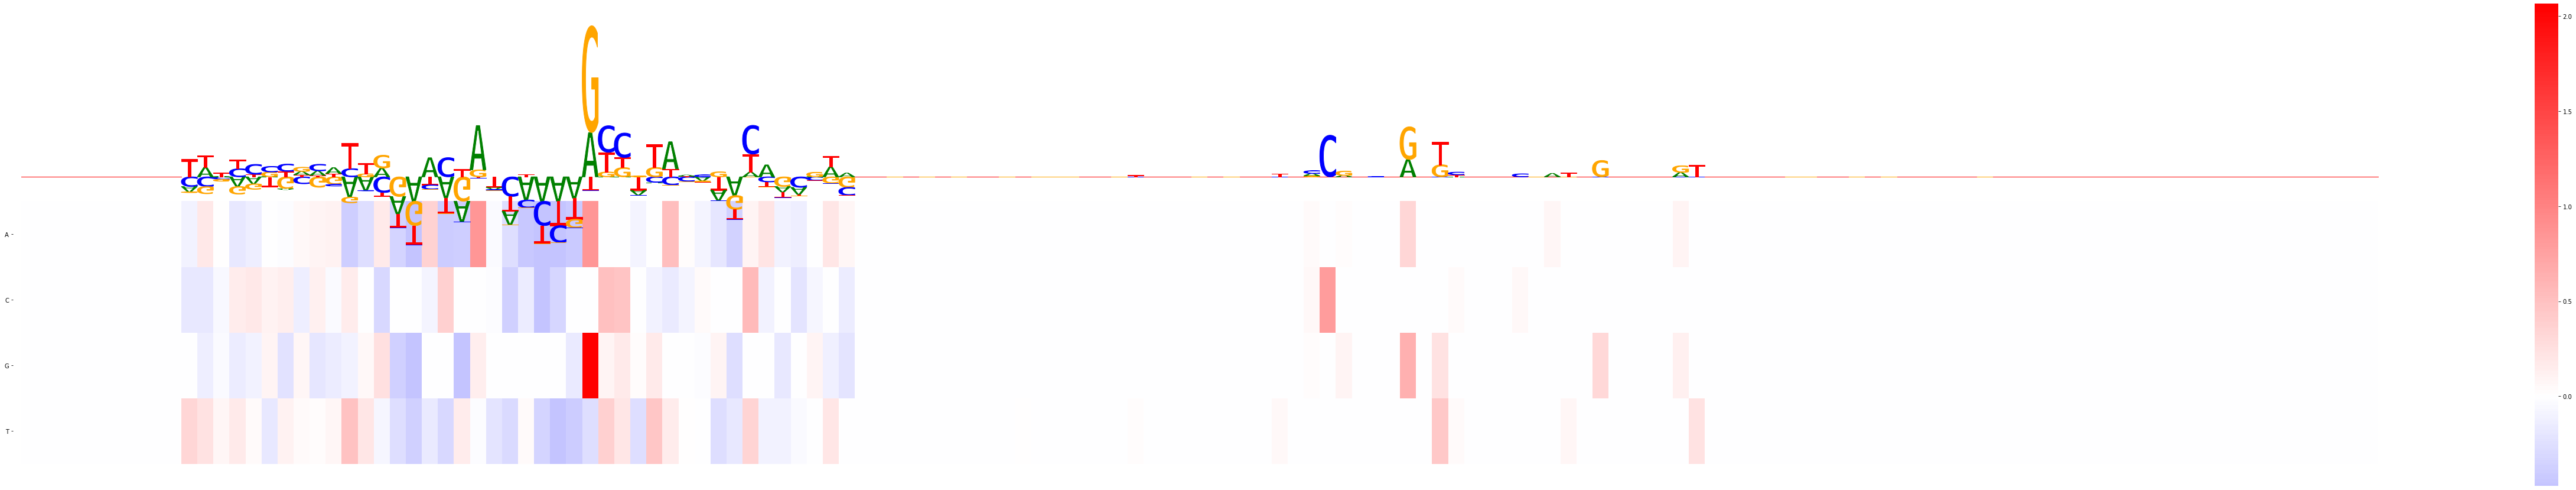

In [49]:
# bigger image - visualize importance scores (height = importance towards transcription-factor DNA binding)
fig = plt.figure(figsize=(90,15))
seqlogo_heatmap(val, val.T, ax=plt.subplot())


## ***In-silico mutagenesis ***

In [0]:
# TODO - update the Mutate function. It should return the following:
# prediction_value:
#   - array
def to_array(isval):
    """Temporary convert the output to a numpy array
    """
    def to_vec(x):
        if x is None:
            return 0
        else:
            if isinstance(x, list):
                return x[0]
            else:
                return x
    return np.array([[to_vec(y) for y in x] for x in isval])


In [0]:
# create class instance to score for ISM mutations using DeepBind model
ism = Mutation(model, "seq")
# score model using Mutation ISM class instance on ChIP-SEQ CTCF dataset
val = to_array(ism.score(data1)[0])



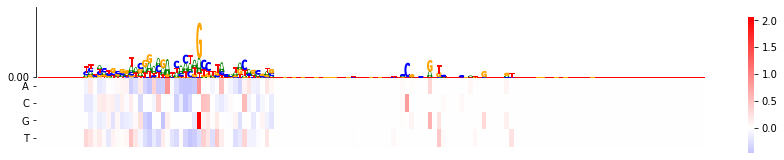

In [43]:
#visualize all possible mutations and strength of binding interaction for given base-pair
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(np.abs(val), val.T, ax=plt.subplot(), show_letter_scale=True)


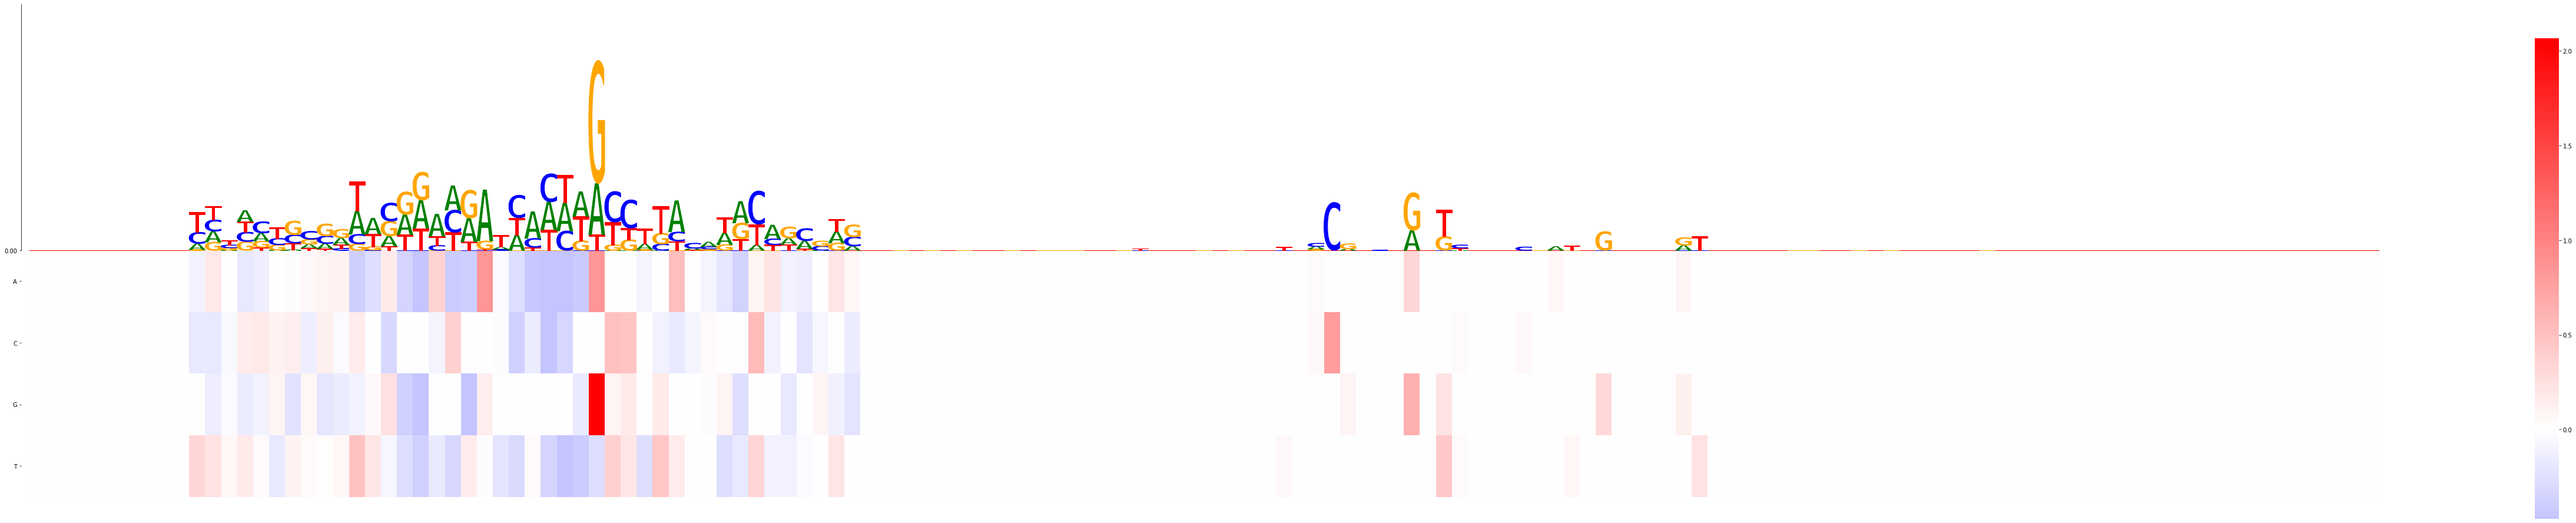

In [48]:
# bigger image
fig = plt.figure(figsize=(90,15))
seqlogo_heatmap(np.abs(val), val.T, ax=plt.subplot(), show_letter_scale=True)
